## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from models import customLogisticRegression
from parameters import ParameterProxy
from lib2 import valid_ifthens_with_coverage_correctness, rules2rulesbyif
import lib2
from formatting import recourse_report_reverse

import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [2]:
### do we need these?

# from aif360.datasets import StandardDataset
# from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
# from aif360.algorithms.postprocessing import RejectOptionClassification
# from aif360.detectors.mdss.ScoringFunctions import Bernoulli
# from aif360.detectors.mdss.MDSS import MDSS
# from aif360.detectors.mdss.generator import get_random_subset

In [3]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"

## Load Dataset

In [4]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


### Print some statistics for the dataset

In [5]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

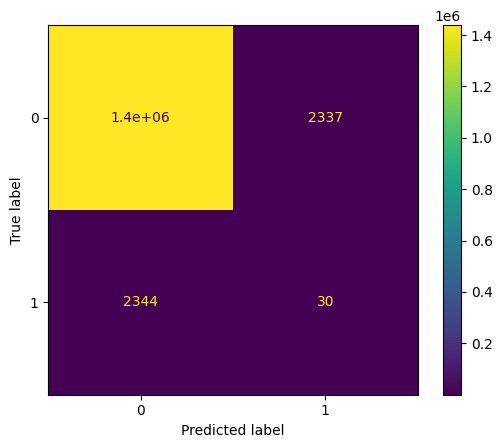

In [6]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [7]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,F,1,55-64,Unknown,Unknown,1,1,0
3,F,1,55-64,Unknown,Unknown,1,1,0
4,F,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,F,1,25-34,Unknown,Unknown,1,1,0
1443136,F,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,F,1,55-64,Unknown,Unknown,1,1,0


In [8]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [9]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

CPU times: total: 15.2 s
Wall time: 7.83 s


array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [10]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    432231
           1       0.00      0.12      0.00       712

    accuracy                           0.89    432943
   macro avg       0.50      0.50      0.47    432943
weighted avg       1.00      0.89      0.94    432943



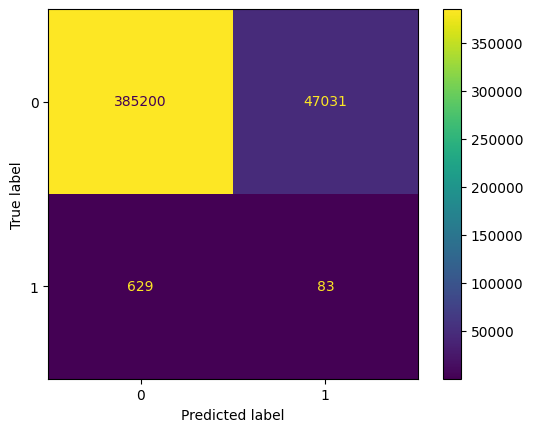

In [11]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# !!!!Testing Area Start!!!!

In [13]:
from frequent_itemsets import runApriori, preprocessDataset, aprioriout2predicateList
from predicate import recIsValid, Predicate

preds = model.predict(X_test)
affected = X_test[preds == 0]
unaffected = X_test[preds == 1]

male_affected = affected[affected.gender == "M"].drop(["gender"], axis=1)
female_affected = affected[affected.gender == "F"].drop(["gender"], axis=1)
unknown_affected = affected[affected.gender == "Unknown"].drop(["gender"], axis=1)

males_aff_preds, male_supps = aprioriout2predicateList(runApriori(preprocessDataset(male_affected)))
females_aff_preds, female_supps = aprioriout2predicateList(runApriori(preprocessDataset(female_affected)))
unknown_aff_preds, unknown_supps = aprioriout2predicateList(runApriori(preprocessDataset(unknown_affected)))

inter = []
for candidate_if in males_aff_preds:
    if candidate_if in females_aff_preds and candidate_if in unknown_aff_preds:
        inter.append(candidate_if)

unaff_preds, _ = aprioriout2predicateList(runApriori(preprocessDataset(unaffected)))

ifthens = [(h, s) for h in inter for s in unaff_preds if recIsValid(h, s)]

In [17]:
from metrics import incorrectRecoursesIfThen, incorrectRecoursesSingle

In [22]:
males_sd = Predicate.from_dict({"gender": "M"})
females_sd = Predicate.from_dict({"gender": "F"})

if1 = ifthens[0][0]
then1 = ifthens[0][1]

In [29]:
%%time

print(incorrectRecoursesSingle(males_sd, if1, then1, male_affected.assign(gender="M"), model))
print(incorrectRecoursesSingle(females_sd, if1, then1, female_affected.assign(gender="F"), model))

5959.0
13695.0
CPU times: total: 2.41 s
Wall time: 7.12 s


In [28]:
%%time

print(incorrectRecoursesIfThen(if1, then1, male_affected.assign(gender="M"), model))
print(incorrectRecoursesIfThen(if1, then1, female_affected.assign(gender="F"), model))

5959.0
13695.0
CPU times: total: 219 ms
Wall time: 625 ms


# !!!!Testing Area End!!!!

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [13]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model,
    sensitive_attribute
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

100%|████████████████████████████████████████████████████████████████████████████████| 317/317 [00:52<00:00,  6.09it/s]

Number of if-thens: 317


Uncomment the following block if you wish to load rules object from disk.

In [28]:
# import dill

# with open("rules.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [38]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(list(rules_by_if_filtered.items()), missing_subgroup_val="Unknown"))

If homeowner = 0, area = Unknown, college_educated = 1, income = Unknown, age = 45-54, parents = 1:
	Subgroup 'F', 0.1789% covered
		Make homeowner = 0, area = Unknown, college_educated = 1, income = <100K, age = 25-34, parents = 1 with correctness 0.0000%.
	Subgroup 'M', 0.1856% covered
		Make homeowner = 0, area = Unknown, college_educated = 1, income = <100K, age = 25-34, parents = 1 with correctness 100.0000%.
If homeowner = 0, area = Unknown, college_educated = 1, age = 55-64, income = Unknown:
	Subgroup 'F', 0.5244% covered
		Make homeowner = 0, area = Unknown, college_educated = 0, age = 55-64, income = Unknown with correctness 0.0000%.
		Make homeowner = 0, area = Unknown, college_educated = 1, age = 25-34, income = Unknown with correctness 100.0000%.
	Subgroup 'M', 0.4929% covered
		Make homeowner = 0, area = Unknown, college_educated = 0, age = 55-64, income = Unknown with correctness 100.0000%.
		Make homeowner = 0, area = Unknown, college_educated = 1, age = 25-34, income =

In [24]:
##### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [26]:
K = 10

rules_max_costdiff_2groups = lib2.sort_triples_by_costdiff_2groups(rules_by_if, "M", "F")[:K]
rules_max_costdiff_2groups = dict(rules_max_costdiff_2groups)

print(recourse_report_reverse(
    list(rules_max_costdiff_2groups.items()),
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown"
))

If income = Unknown, homeowner = 1, area = Unknown, age = Unknown:
	Subgroup 'F', 1.7305% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness -0.0000%.
	Subgroup 'M', 1.9012% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 94.8520%.
If income = Unknown, homeowner = 1, area = Urban:
	Subgroup 'F', 21.4659% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown with correctness 1.6171%.
	Subgroup 'M', 22.6137% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown with correctness 91.1491%.
If college_educated = 1, parents = 1, homeowner = 1, area = Unknown, age = Unknown, income = Unknown:
	Subgroup 'F', 1.5458% covered out of 600135
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = Unknown with correctness 0.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 5

# Generalize to arbitrary number of subgroups



In [25]:
comparators = lib2.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

In [36]:
rules_max_costdiff_sorted = lib2.sort_triples_by_max_costdiff(rules_by_if)

print(recourse_report_reverse(
    rules_max_costdiff_sorted[:K],
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown"
))

If income = Unknown, homeowner = 1, area = Unknown, age = Unknown:
	Subgroup 'F', 1.7305% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness -0.0000%.
	Subgroup 'M', 1.9012% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 94.8520%.
If income = Unknown, homeowner = 1, area = Urban:
	Subgroup 'F', 21.4659% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown with correctness 1.6171%.
	Subgroup 'M', 22.6137% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown with correctness 91.1491%.
If college_educated = 1, parents = 1, homeowner = 1, area = Unknown, age = Unknown, income = Unknown:
	Subgroup 'F', 1.5458% covered out of 600135
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = Unknown with correctness 0.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 5

# Find fairness-oriented counterfactuals (the same as above) for all features as sensitive!

In [14]:
all_attributes = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
rules = {attr: [] for attr in all_attributes}

for attr in all_attributes:
    rules[attr] = valid_ifthens_with_coverage_correctness(
        X_test,
        model,
        sensitive_attribute=attr
    )
    rules[attr] = lib2.sort_triples_by_max_costdiff(rules[attr])

 14%|███████████▍                                                                     | 45/317 [00:19<02:00,  2.25it/s]


KeyboardInterrupt: 